<a href="https://colab.research.google.com/github/saif9402/Dr-Wessam-Project/blob/main/HashingVectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d anupampaul005/fake-news-dataset

Dataset URL: https://www.kaggle.com/datasets/anupampaul005/fake-news-dataset
License(s): MIT
fake-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -o fake-news-dataset.zip

Archive:  fake-news-dataset.zip
  inflating: dataset.csv             


In [ ]:
!pip install -q scikit-learn tensorflow matplotlib nltk

In [ ]:
import numpy as np
import pandas as pd
import re, string
import nltk

from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from sklearn.svm import LinearSVC
model = LinearSVC(max_iter=10_000)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# Cell 2: Load dataset
# Adjust file path if your CSV has a different name
df = pd.read_csv('dataset.csv')
# Combine title and text into a single feature
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
# Map the unreliable column to a binary label
df['label'] = df['unreliable']

# Cell 3: Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text: str) -> str:
    """Lowercase, remove punctuation/digits, stopwords, and lemmatize."""
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    tokens = [lemmatizer.lemmatize(tok) for tok in text.split() if tok not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
df['clean_content'] = df['content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Cell 4: Train/Test split
X = df['clean_content']
y = LabelEncoder().fit_transform(df['label'])

X_train_full, X_test,  y_train_full, y_test  = train_test_split(
    X, y,          test_size=0.2,  random_state=42
)

# then split your training set into train + validation
X_train,      X_val,   y_train,      y_val     = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25,       # 0.25 x 0.8 = 0.2 of original → 20% val
    random_state=42
)

In [ ]:
# Cell 5: Feature extraction using HashingVectorizer
n_features = 2**16  # 65,536 dimensions
vectorizer = HashingVectorizer(
    n_features=n_features,
    alternate_sign=False,
    norm=None,
    ngram_range=(1, 2),
    binary=False
)
X_train_hv = vectorizer.transform(X_train)
X_test_hv = vectorizer.transform(X_test)

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(C=10, max_iter=1000, n_jobs=-1),
    'RandomForest':      RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'LinearSVC':         LinearSVC(max_iter=10000, random_state=42)
}

In [ ]:
for name, model in models.items():
    model.fit(X_train_hv, y_train)

    train_preds = model.predict(X_train_hv)
    train_acc   = accuracy_score(y_train, train_preds)

    # 3. Test‐set predictions & metrics
    test_preds  = model.predict(X_test_hv)
    test_acc    = accuracy_score(y_test, test_preds)
    prec        = precision_score(y_test, test_preds)
    rec         = recall_score(y_test, test_preds)
    f1          = f1_score(y_test, test_preds)

    # 4. AUC (ROC)
    # probs       = model.predict_proba(X_test_hv)[:, 1]
    # fpr, tpr, _ = roc_curve(y_test, probs)
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test_hv)[:, 1]
    else:
        scores = model.decision_function(X_test_hv)

    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc     = auc(fpr, tpr)

    # 5. Print them all
    print(
        f"{name}: "
        f"  Train Acc = {train_acc:.4f}, "
        f"  Test  Acc = {test_acc:.4f}, "
        f"  Precision = {prec:.4f}, "
        f"  Recall    = {rec:.4f}, "
        f"  F1-Score  = {f1:.4f}, "
        f"  AUC       = {roc_auc:.4f}\n"

    )


LogisticRegression:   Train Acc = 1.0000,   Test  Acc = 0.9702,   Precision = 0.9681,   Recall    = 0.9745,   F1-Score  = 0.9713,   AUC       = 0.9921

RandomForest:   Train Acc = 1.0000,   Test  Acc = 0.9555,   Precision = 0.9747,   Recall    = 0.9380,   F1-Score  = 0.9560,   AUC       = 0.9911

LinearSVC:   Train Acc = 1.0000,   Test  Acc = 0.9628,   Precision = 0.9585,   Recall    = 0.9699,   F1-Score  = 0.9641,   AUC       = 0.9897



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


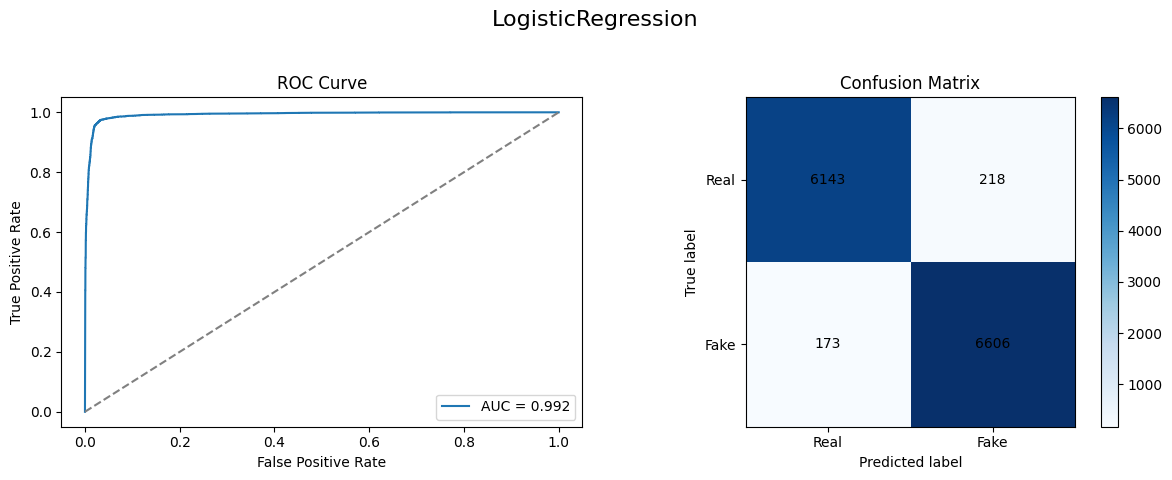

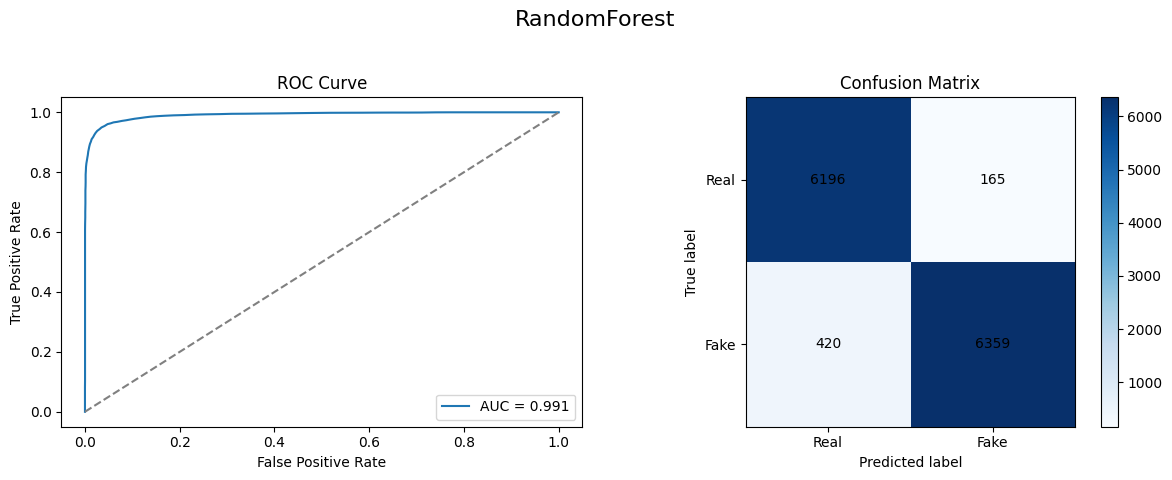

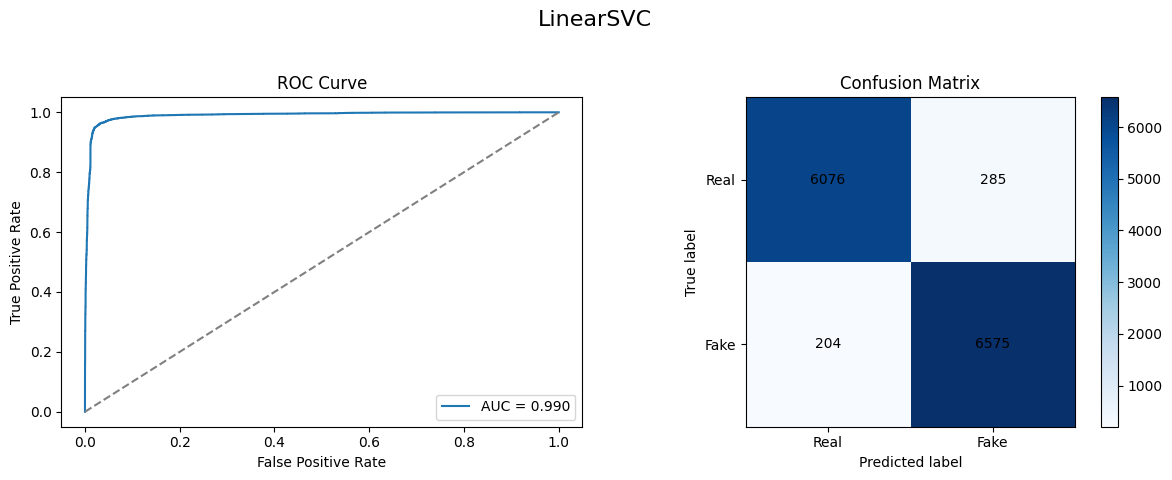

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

for name, model in models.items():
    # — compute scores for ROC
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test_hv)[:, 1]
    else:
        scores = model.decision_function(X_test_hv)
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)

    # — compute confusion matrix
    y_pred = model.predict(X_test_hv)
    cm     = confusion_matrix(y_test, y_pred)
    classes = ["Real", "Fake"]  # adjust if your labels differ

    # — plot both in one figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{name}", fontsize=16)

    # ROC curve
    ax1.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax1.plot([0, 1], [0, 1], "--", color="gray")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("ROC Curve")
    ax1.legend(loc="lower right")

    # Confusion matrix
    im = ax2.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax2.set_title("Confusion Matrix")
    fig.colorbar(im, ax=ax2)
    ax2.set_xticks(np.arange(len(classes)))
    ax2.set_yticks(np.arange(len(classes)))
    ax2.set_xticklabels(classes)
    ax2.set_yticklabels(classes)
    ax2.set_xlabel("Predicted label")
    ax2.set_ylabel("True label")
    # annotate counts
    for i, j in np.ndindex(cm.shape):
        ax2.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
pip install tensorflow

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
max_len = 200

def prepare_lstm_data(X):
    return pad_sequences(
        tokenizer.texts_to_sequences(X),
        maxlen=max_len, padding='post'
    )

X_train_pad = prepare_lstm_data(X_train)
X_val_pad   = prepare_lstm_data(X_val)
X_test_pad  = prepare_lstm_data(X_test)

lstm_model = Sequential([
    Embedding(5000, 64, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# set up your EarlyStopping callback
early_stop = EarlyStopping(
    patience=3,
    restore_best_weights=True  # optional but often helpful
)

# train once and capture history
history = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# extract final train accuracy
train_acc = history.history['accuracy'][-1]

# evaluate on test set
test_loss, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)

# get predicted probabilities and classes
y_pred_prob = lstm_model.predict(X_test_pad).ravel()
y_pred      = (y_pred_prob >= 0.5).astype(int)

# compute precision, recall, f1
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

# compute AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc_score   = auc(fpr, tpr)

# print everything
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-Score       : {f1:.4f}")
print(f"AUC            : {auc_score:.4f}")


Epoch 1/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 143s 113ms/step - accuracy: 0.7583 - loss: 0.4799 - val_accuracy: 0.9197 - val_loss: 0.2315
Epoch 2/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 141s 112ms/step - accuracy: 0.9072 - loss: 0.2576 - val_accuracy: 0.6616 - val_loss: 0.5620
Epoch 3/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 140s 114ms/step - accuracy: 0.7905 - loss: 0.4172 - val_accuracy: 0.9452 - val_loss: 0.1603
Epoch 4/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.9558 - loss: 0.1351 - val_accuracy: 0.9511 - val_loss: 0.1298
Epoch 5/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 152s 123ms/step - accuracy: 0.9734 - loss: 0.0888 - val_accuracy: 0.9619 - val_loss: 0.1183
Epoch 6/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 198s 120ms/step - accuracy: 0.9819 - loss: 0.0614 - val_accuracy: 0.9613 - val_loss: 0.1246
Epoch 7/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 202s 120ms/step - accuracy: 0.9876 - loss: 0.0438 - val_accuracy: 0.9639 - val_loss: 0.1255
Epoch 8/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 149s 121ms/step - ac

411/411 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step


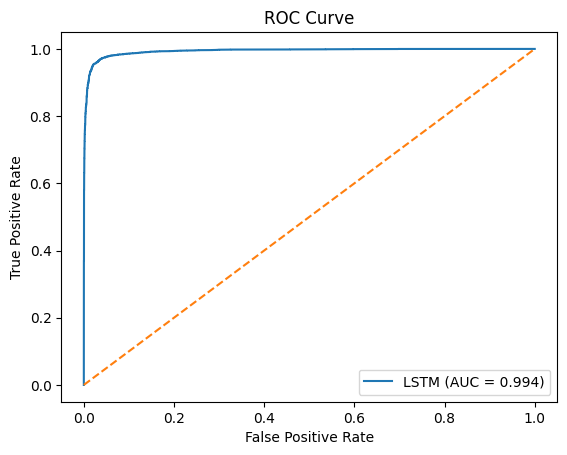

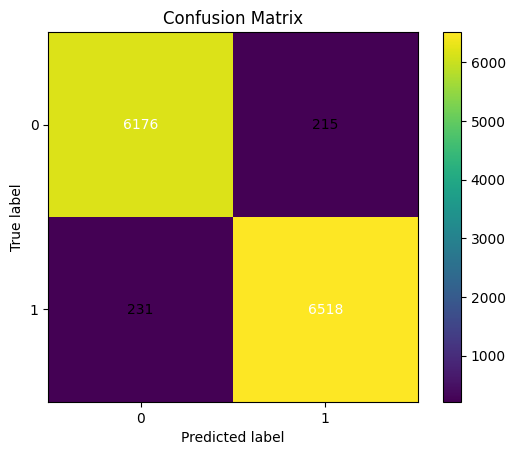

In [ ]:
# Cell X: ROC Curve & Confusion Matrix

from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# 1. Predict probabilities for the positive class
y_pred_prob = lstm_model.predict(X_test_pad).flatten()

# 2. ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc     = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'LSTM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Confusion matrix
#    Threshold at 0.5 for binary classification
y_pred = (y_pred_prob >= 0.5).astype(int)
cm     = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = range(2)
plt.xticks(tick_marks, ['0','1'])
plt.yticks(tick_marks, ['0','1'])

# 4. Annotate each cell with the count
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()
